# Terrain Preprocessing - General Data
### Created by Keenan McConkey 2019.8.12

Imports raw IMU data collected from DAQ modules mounted to the wheelchair for each user, runs this data through filtering, windowing, feature extraction, and standardization, and processed data to csv to be used for classification

In [1]:
# Import relevant modules

from __future__ import absolute_import, division, print_function

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

### Notebook Parameters

You can change these to run the notebook on different subsets of data.

In [2]:
USER = 'All' # Which users data to run preprocessing on. 'All' runs on everyones data
WINDOW_SIZE_IN_SEC = 3.0 # Length of data windows for both frame and wheel, standard is 1.0
POWER_TYPE = 'Manual' # Either 'Manual' or 'Power' wheelchair mode

EXPORT_PROCESSED_DATA = True
EXPORT_SCALERS = False

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [3]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used for classification
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ', 'ACCELEROMETER XY (m/s²)']

# Differs for synthesis data (as usual)
unused_columns_synth = ['ACCELEROMETER X (m/s²)']

'''Get columns for given label'''
def get_columns(label):
    # Columns differ for synthesis data
    if 'Middle' in label or 'Left' in label or 'Right' in label:
        columns = std_columns.copy()
    elif 'Synthesis' in label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in label or 'PSD' in label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [4]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSDLog', 'PSD']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [5]:
# Find .csv files
# TODO: Split according to user and create a dictionary of all users
raw_datasets = {}

# Power and manual data stored in separate folders
if POWER_TYPE == 'Manual':
    power_type_folder = 'set_manual/'
elif POWER_TYPE == 'Power':
    power_type_folder = 'set_power/'
else:
    raise Exception('Unknown power type!')
    
# Glob all files in the folder
glob_paths = glob.glob('imu_data/new_setup/' + power_type_folder + '*.csv')

# Remove 9250 9-axis IMU data (for now)
glob_paths = [path for path in glob_paths if '9250' not in path]

# Keenan is "default" user so files without any username are assumed to be his
if USER == 'All':
    dataset_paths = glob_paths
elif USER == 'Keenan':
    dataset_paths = [path for path in glob_paths if 'Mahsa' not in path and 'Kevin' not in path 
                                                and 'Jamie' not in path]
elif USER == 'Mahsa' or USER == 'Kevin' or USER == 'Jamie':
    dataset_paths = [path for path in glob_paths if USER in path]
else:
    raise Exception('Unknown user!')

In [6]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)
    
    # Drop unused columns
    if 'Synthesis' in dataset_label:
        unused = [unused_column for unused_column in unused_columns_synth if unused_column in dataset.columns]
    else:
        unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to easier to work with names
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in sec
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle frame data
    ## Can't remove from wheel-mounted Left and Right wheel data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns to put Run Time and Epoch Time at the end
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    # Use different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Vel'
        STARTUP_THRESH = 0.1
    else:
        thresh_axes = 'Z Accel'
        STARTUP_THRESH = 2.0
        
    # Caluclate first and last instance above threshold and use as the time domain
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [7]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time']

In [8]:
# Sort dictionary according to keys
raw_datasets = {label: raw_datasets[label] for label in sorted(raw_datasets.keys())}

# Save list of keys to variable
dataset_labels = list(raw_datasets.keys())
print('Number of raw datasets: {}'.format(len(dataset_labels)))

Number of raw datasets: 333


In [9]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2971,-6.697752,-8.063040,2.459991,-0.721819,-0.570255,1.892346,8.915,1.565202e+09
2972,-7.295096,-8.195917,-0.677562,-0.720754,-0.548417,1.924037,8.918,1.565202e+09
2973,-6.226102,-7.138893,-2.937654,-0.666692,-0.510068,1.951202,8.921,1.565202e+09
2974,-5.175063,-7.549492,-1.483198,-0.668023,-0.519922,1.974638,8.924,1.565202e+09
2975,-4.813545,-7.622514,2.151144,-0.694921,-0.514595,2.010058,8.927,1.565202e+09


### Part (b) - Visualizing Time Domain Data

In [10]:
'''Plot a single Pandas dataset for given x and y axes'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    # Figure parameters
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    # Add relevant units to y label
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    # Use limits if they've been passed in
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Plot relevant data
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

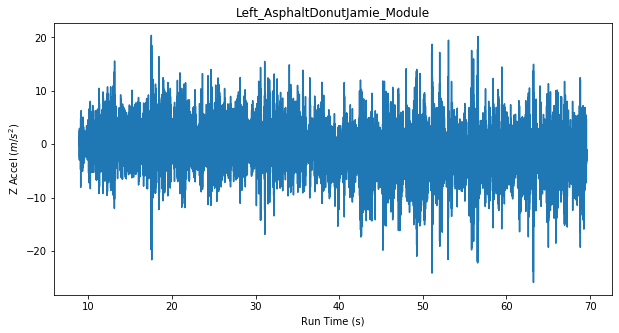

In [11]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Z Accel')

In [12]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [13]:
'''Compare two Pandas datasets by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, y_axis, t_offset=0, y_offset=0):
    # Plot parameters
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_title(y_axis + ' for ' + label1 + ' and ' + label2)
        
    # Add relevant units to y label
    if 'Gyro' in y_axis:
        ax.set_ylabel(y_axis + ' ($rad/s$)')
    elif 'Accel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s^2$)')
    elif 'Vel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s$)')
    else:
        ax.set_ylabel('Unknown')
    
    # Plot data with given y and t offsets applied to first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][y_axis].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][y_axis], label=label2)
    
    # Include offset info text in plot
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [14]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                y_axis='Z Gyro')

In [15]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    # Set paramaeters based on number of datasets to plot
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 0
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
    axes = []
    row, col = 0, 0
    
    # Plot each of the given datasets
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

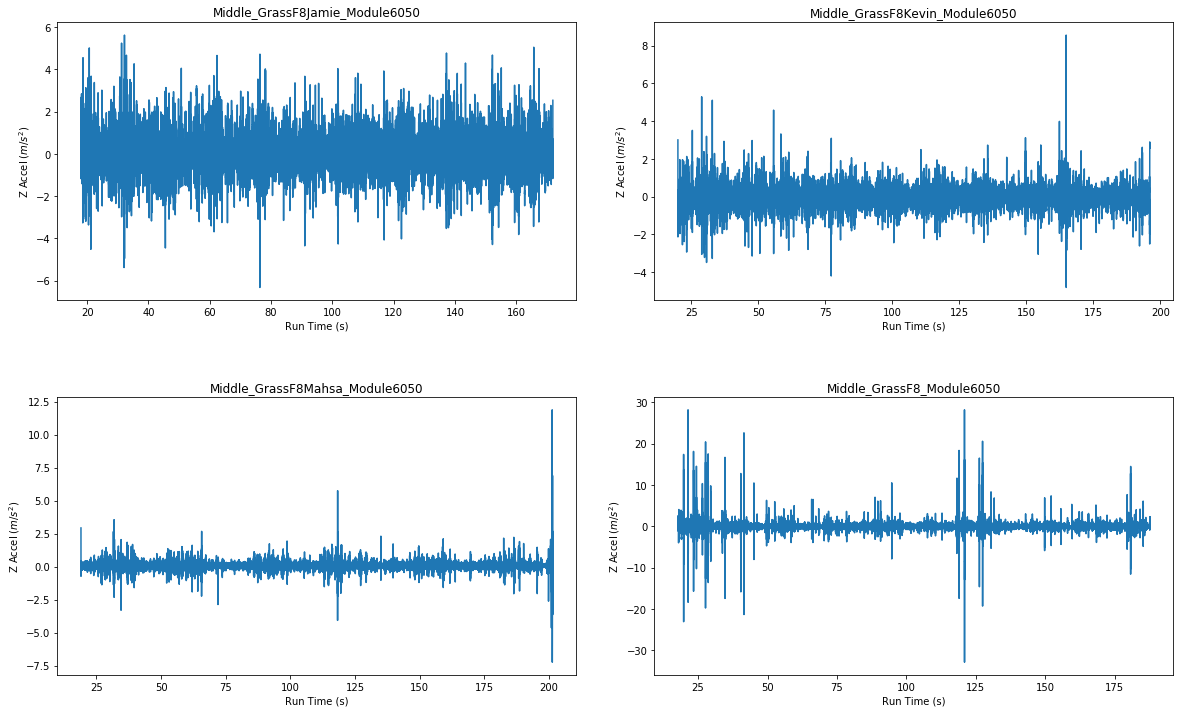

In [16]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() 
                    if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [17]:
# TODO: Check whether its necessary to convert to Numpy

'''Convert array of Pandas DataFrames to array of 2D NumPy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [18]:
'''Convert array of 2D NumPy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))     
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [19]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [20]:
# Run to convert back to Pandas
raw_datasets = np_to_pd(raw_datasets)

In [21]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 333
Shape of first dataset: (20222, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [22]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    ## Currently not using high pass frequency
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label')
        
    return f_samp, f_low, f_high

In [23]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    # Sampling frequency differs varies between frame and wheel modules
    # Synthesis data is created from combining left and right wheel data so it has the same samp rate
    # Window size in seconds = Window size / Sampling rate
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = int(WINDOW_SIZE_IN_SEC * 333)
    elif 'Middle' in label:
        window_size = int(WINDOW_SIZE_IN_SEC * 300)
    else:
        raise Exception('Unknown label')
        
    return window_size

In [24]:
'''Get number of data columns in dataset with given label'''
def get_n_data_col(label):
    # Different number of columns for Synthesis datasets
    if 'Synthesis' in label:
        n_col = 16
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [25]:
# Filtered datasets dictionary
datasets = {}

# Filter each dataset individually
for label, raw_dataset in raw_datasets.items():
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:, i])
        
    datasets.update({label: dataset})

In [26]:
# Check construction of filtered dataset
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 333
Shape of first filtered dataset: (20222, 8)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-6.698429,-8.063168,2.458648,-0.721819,-0.570230,1.892358,8.915,1.565202e+09
1,-6.528537,-7.894444,-0.583850,-0.693312,-0.545581,1.920505,8.918,1.565202e+09
2,-6.135618,-7.666894,-1.829945,-0.677845,-0.526474,1.948840,8.921,1.565202e+09
3,-5.608335,-7.356281,-0.994583,-0.682656,-0.512938,1.978671,8.924,1.565202e+09
4,-5.247871,-7.025428,0.649326,-0.704289,-0.501146,2.011160,8.927,1.565202e+09


Note: Already a Pandas dataframe!


<Figure size 432x288 with 0 Axes>

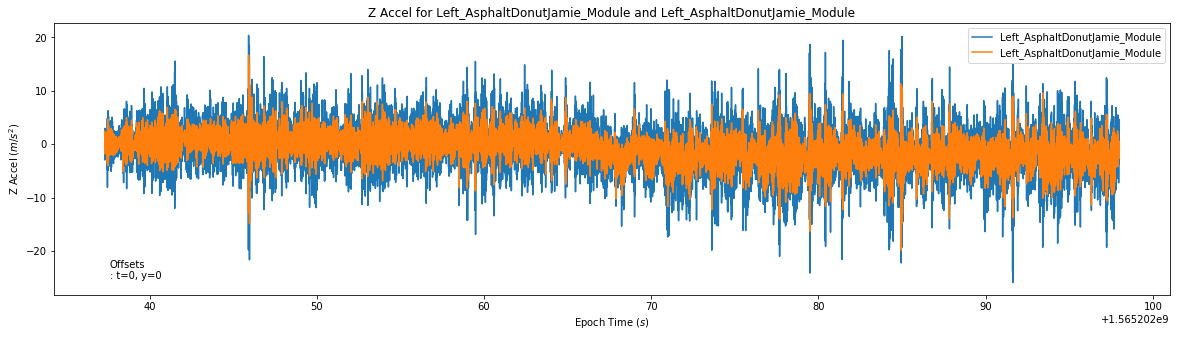

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'Z Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to Z Gyro calculated by combining wheel data, for Pandas data
   Essentially replicates the process of calculating Z Gyro in Synthesis data'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro using wheel data
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [31]:
# TODO: Create dictionary of different window sizes for comparing

datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Total windows that fit in the dataset
    n_points = n_windows * window_size # Total number of points that fit in non-overlapping windows
    
    # Windowed data
    dataset_windowed = []
    
    # Iterate through dataset by half a window at a time and extract windows
    i = 0
    window_slide = int(window_size / 2)
    
    while (i < n_points):
        dataset_windowed.append(dataset[i:i + window_size])
        i += window_slide
    
    datasets_windowed.update({label: dataset_windowed})

In [32]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 333
Num of windows in first dataset: 41
Shape of individual window: (999, 8)


In [33]:
# Try out Pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
994,2.609097,11.037379,0.490498,0.196020,0.830100,3.810805,11.897,1.565202e+09
995,2.431135,10.125961,0.083015,0.189309,0.843904,3.820717,11.900,1.565202e+09
996,2.397414,8.338187,0.031172,0.189550,0.861015,3.835825,11.903,1.565202e+09
997,2.743281,7.177330,0.295221,0.209432,0.867310,3.851299,11.906,1.565202e+09
998,3.413083,7.698947,0.726244,0.267958,0.858409,3.860276,11.909,1.565202e+09


<Figure size 432x288 with 0 Axes>

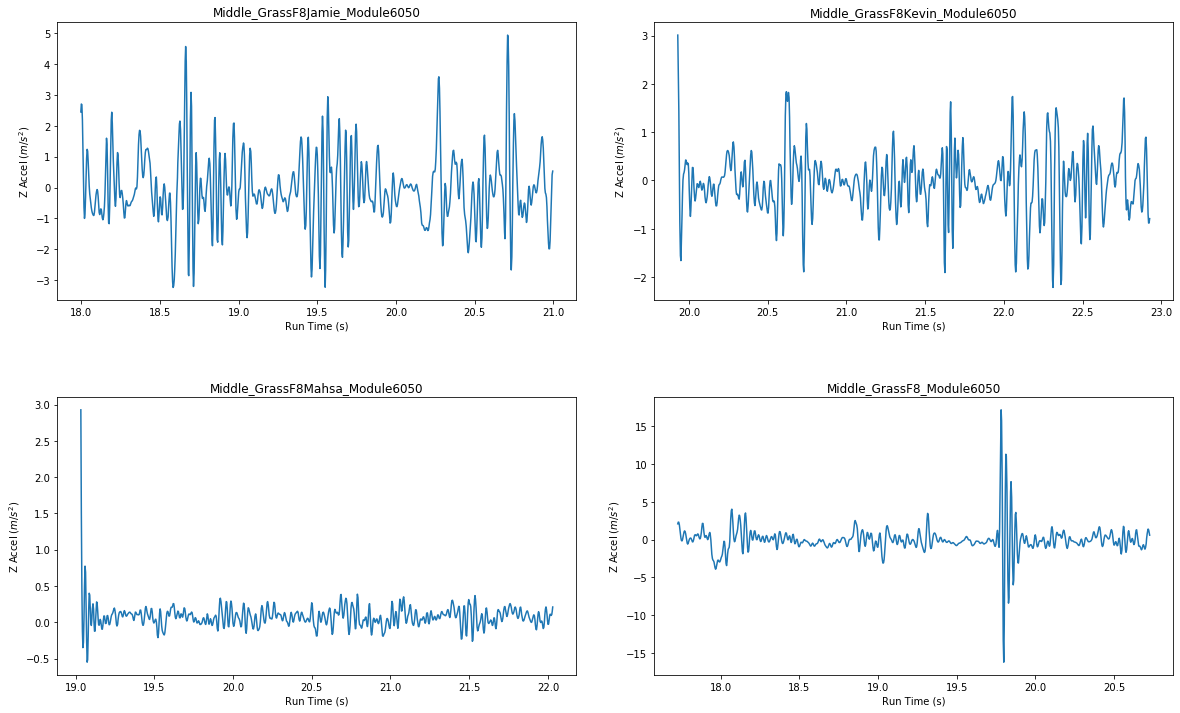

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items()
                    if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Z Accel', windowed=True, win_num=0)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
# Butterworth filter bandpass isn't a perfect edge so there is still some relevant data past the cutoff
N_BINS_OVER_CUTOFF = 5

In [38]:
'''Plot transform of given direction and window of a windowed NumPy dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name, bar=False):
    plt.clf()
    plt.figure(figsize=(10, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        # If bar graph
        if bar:
            plt.bar(np.add(dataset[win_num][:, -1], 1), dataset[win_num][:, dirn])
        else:
            plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                     label=label)
    if not bar: 
        plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    plt.show()

### Part (a) - FFT

In [39]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Get relevant parameters for given label
        f_samp, f_low, f_high = get_frequencies(label)        
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            # TODO: Look into complex output of fft function
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + '_FFT': dataset_fft})

In [40]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'_FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'_FFT'][0].shape))

# Test Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'_FFT'][0].head()

Num of FFT'd windowed datasets: 333
Num of FFT'd windows in first dataset: 115
Shape of FFT'd individual window: (184, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,2.048444,1.376843,0.237950,0.270168,0.088306,2.956888,0.000000
1,3.641739,3.390879,0.041687,0.295278,0.311823,0.170492,0.333634
2,2.348657,3.008420,0.043816,0.201332,0.247540,0.274225,0.667267
3,0.568625,0.734664,0.075267,0.124485,0.071273,0.164324,1.000901
4,0.736455,0.783259,0.082260,0.052335,0.043642,0.119664,1.334535


<Figure size 432x288 with 0 Axes>

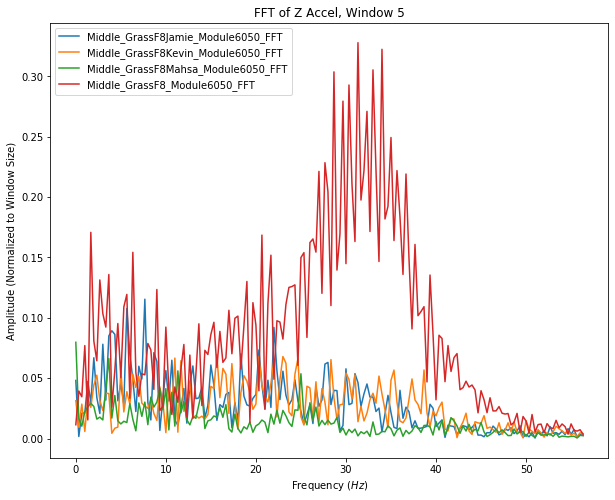

In [41]:
# Compare some FFTs
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items()
                if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_set_transforms(ffts_to_plot, win_num=5, dirn=2, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

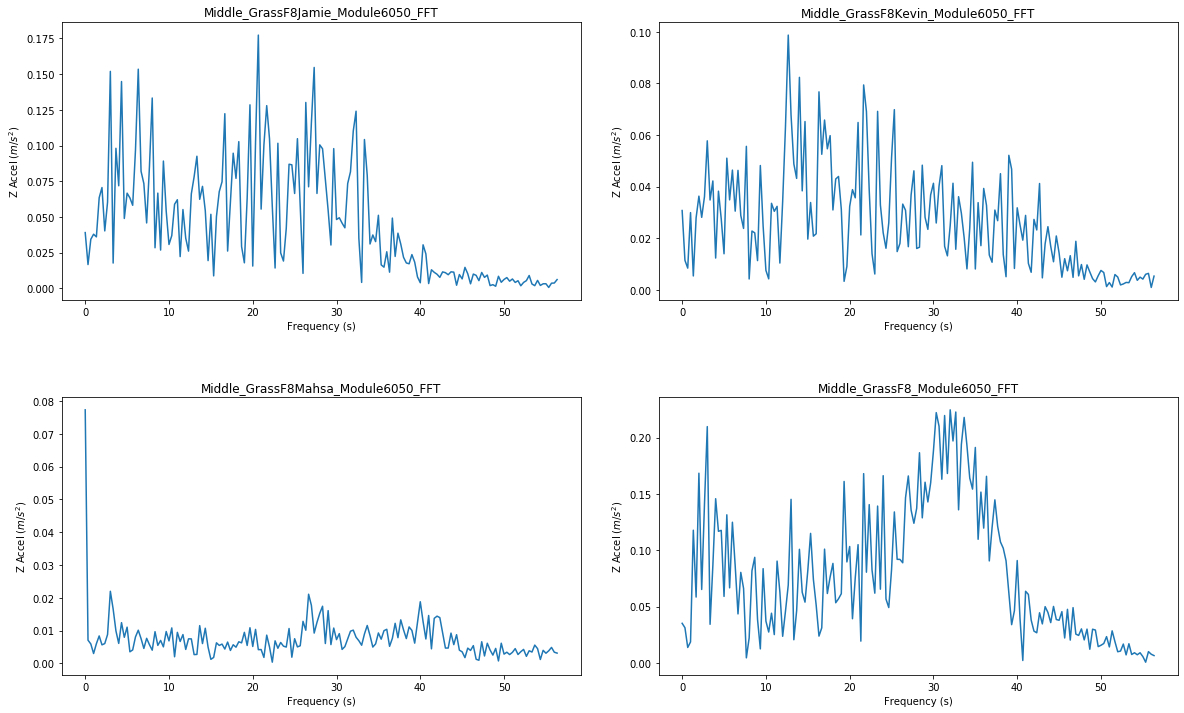

In [42]:
# Compare some FFTs
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [43]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + '_PSD': dataset_psd})
    datasets_psd_log.update({label +'_PSDLog': dataset_psd_log})

In [44]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'_PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'_PSD'][0].shape))

Num PSD'd windowed datasets: 333
Num of PSD'd windows in first dataset: 41
Shape of PSD'd individual window: (184, 7)


<Figure size 432x288 with 0 Axes>

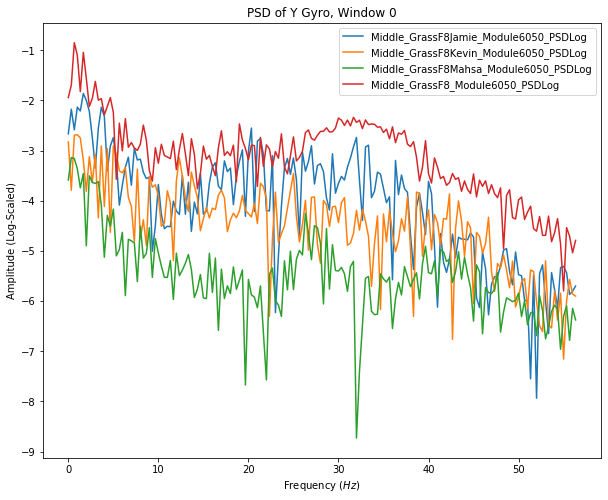

In [45]:
# Compare some Log PSDs
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() 
                if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=4, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

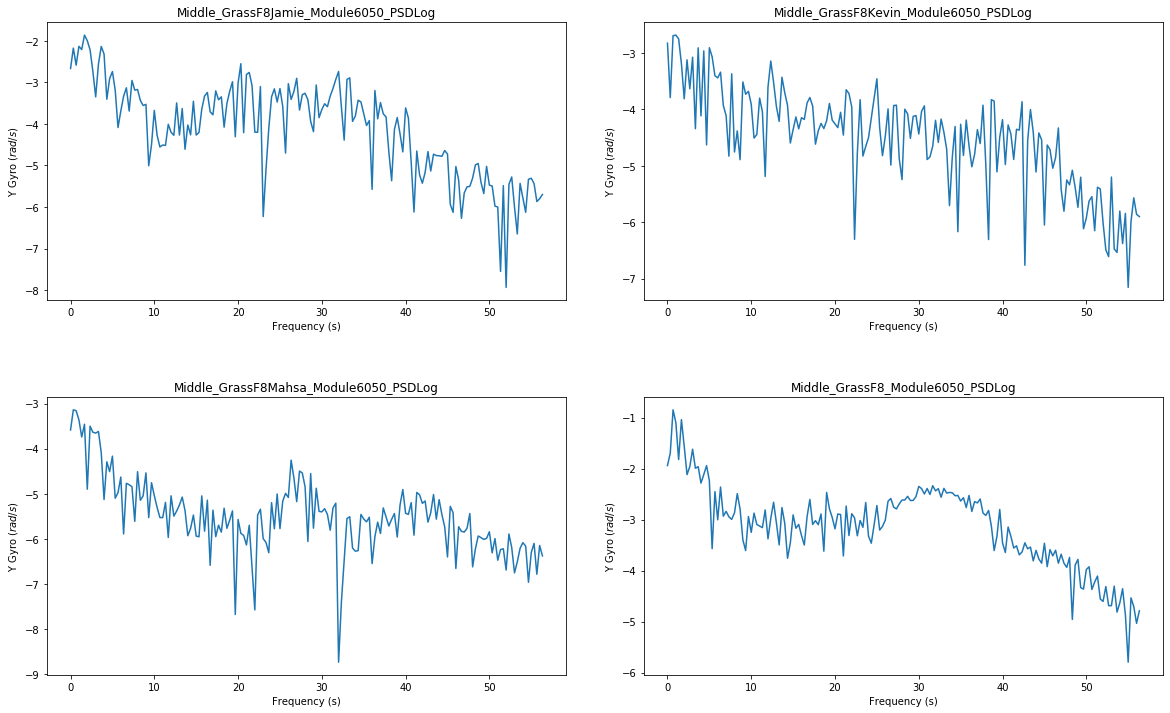

In [46]:
# Compare some Log PSDs
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Y Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [47]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific plot parameters for different transforms
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    
    plt.show()

<Figure size 432x288 with 0 Axes>

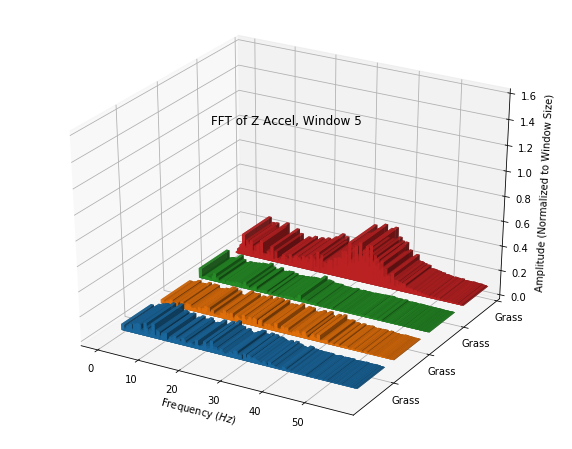

In [48]:
# Compare some FFTs in 3D
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items()
                if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_transforms_3d(ffts_to_plot, win_num=5, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

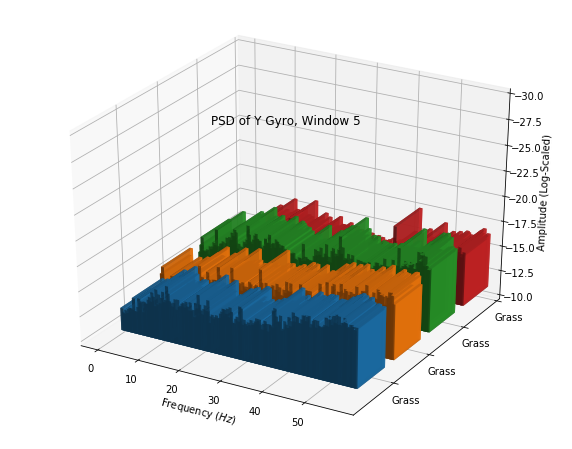

In [49]:
# Compare some PSDs in 3D
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items()
                if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_transforms_3d(psds_to_plot, win_num=5, dirn=4, transform_name='PSD')

### Part (d) - Spectograms

In [50]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

In [51]:
#plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

Extract relevant features (e.g. Mean, Min, Skew, ...) from each data window

In [52]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Find locations where array > 0, put -1 and 1 for each rising/falling point from 0,
    # divide by total datapoints in window
    return len(np.nonzero(np.diff(array > 0.0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [53]:
'''Extract given features from column of each dataset
   Converts a dictionary of datasets to a nested dictionary where each dataset has its own dictionary
   of axes/directions'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window        
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('_PSD', ''): directions})
    
    return datasets_feat

In [54]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
    
    # Set limits if they've been given
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [55]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std': np.std,  'Norm': l2norm, 'AC': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'RMS': rms, 'ZCR': zcr, 
                 'Skew': stats.skew, 'EK': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [56]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 333
Num directions: 6
Shape of first dataset first direction: (41, 10)


In [57]:
datasets_feat_time[dataset_labels[0]]['X Accel'].head()

,Mean,Std,Norm,AC,Max,Min,RMS,ZCR,Skew,EK
0,-2.048444,6.480350,214.813562,46144.866396,12.992936,-12.370650,6.796400,0.007007,0.540773,-1.006325
1,-0.681868,6.970877,221.379803,49009.017081,14.104842,-13.132956,7.004147,0.005005,0.188517,-1.346153
2,1.280782,7.310425,234.579712,55027.641492,14.104842,-13.132956,7.421774,0.003003,-0.194385,-1.423702
3,2.087025,6.422492,213.444311,45558.473977,12.357303,-11.412418,6.753079,0.008008,-0.302082,-1.183321
4,1.623234,6.802377,221.039165,48858.312551,20.124759,-12.241679,6.993370,0.009009,-0.104263,-1.052041


<Figure size 432x288 with 0 Axes>

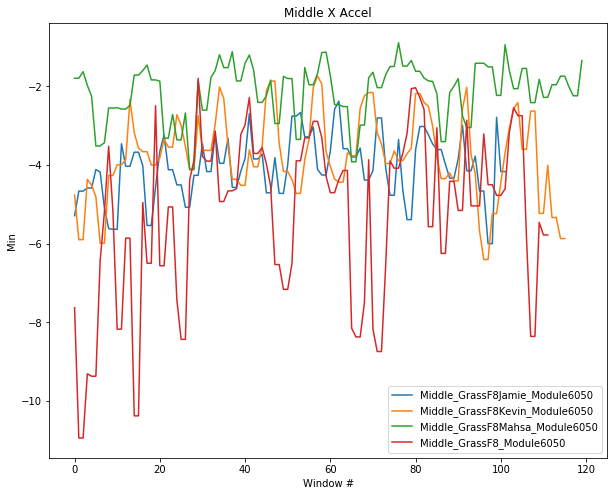

In [58]:
# Plot some time feature data
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items()
                         if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [59]:
# Frequency domain feature functions and names
freq_features = {'MSF': msf, 'RMSF': rmsf, 'FC': fc, 'VF': vf, 'RVF': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [60]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 333
Num directions: 6
Shape of one direction: (41, 5)


In [61]:
datasets_feat_freq[dataset_labels[0]]['X Accel'].head()

,MSF,RMSF,FC,VF,RVF
0,3.084835,1.756370,0.950030,2.182278,1.756370
1,20.170676,4.491178,1.660391,17.413777,4.491178
2,33.005831,5.745070,1.522403,30.688119,5.745070
3,21.024398,4.585237,0.950348,20.121236,4.585237
4,18.716018,4.326201,2.879241,10.425990,4.326201


<Figure size 432x288 with 0 Axes>

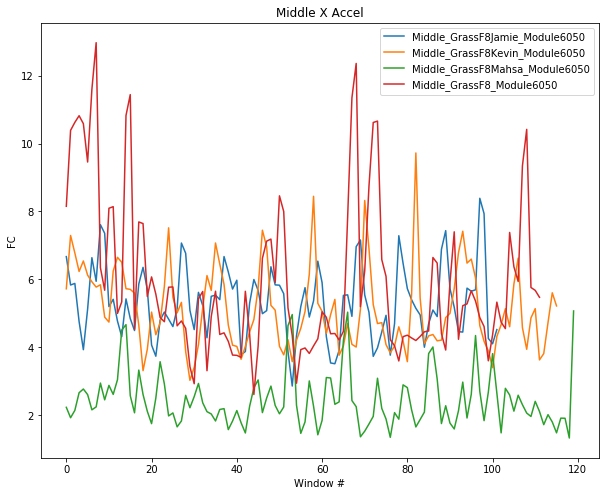

In [62]:
# Plot some frequency feature data
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items()
                         if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='FC', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Columning, Combination, and Standardization of Datasets

In [63]:
# Convert transform data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

### Part (a) - Columning Data

Combine IMU data from each direction into single dataframes with columns for each feature in each direction

In [64]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

#### Part (i) - Extracted Featured Data

In [65]:
'''Combined directions (axes) of a featured dataset'''
def combine_extracted_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [66]:
# Take time feature data and combine axes columns
datasets_feat_time_columned = combine_extracted_columns(datasets_feat_time)

# Confirm formatting
datasets_feat_time_columned[dataset_labels[0]].head()

,Mean X Accel Left,Std X Accel Left,Norm X Accel Left,AC X Accel Left,Max X Accel Left,Min X Accel Left,RMS X Accel Left,ZCR X Accel Left,Skew X Accel Left,EK X Accel Left,...,Mean Z Gyro Left,Std Z Gyro Left,Norm Z Gyro Left,AC Z Gyro Left,Max Z Gyro Left,Min Z Gyro Left,RMS Z Gyro Left,ZCR Z Gyro Left,Skew Z Gyro Left,EK Z Gyro Left
0,-2.048444,6.480350,214.813562,46144.866396,12.992936,-12.370650,6.796400,0.007007,0.540773,-1.006325,...,2.956888,0.585586,95.273356,9077.012362,4.013827,1.892358,3.014316,0.0,0.181496,-1.115400
1,-0.681868,6.970877,221.379803,49009.017081,14.104842,-13.132956,7.004147,0.005005,0.188517,-1.346153,...,3.311582,0.369063,105.317041,11091.679071,3.860276,2.376084,3.332084,0.0,-0.738286,-0.077252
2,1.280782,7.310425,234.579712,55027.641492,14.104842,-13.132956,7.421774,0.003003,-0.194385,-1.423702,...,3.712086,0.234152,117.560946,13820.576122,4.297665,3.242046,3.719464,0.0,0.470378,-0.304139
3,2.087025,6.422492,213.444311,45558.473977,12.357303,-11.412418,6.753079,0.008008,-0.302082,-1.183321,...,3.616818,0.320760,114.765295,13171.073024,4.297665,2.945370,3.631013,0.0,0.068581,-0.777036
4,1.623234,6.802377,221.039165,48858.312551,20.124759,-12.241679,6.993370,0.009009,-0.104263,-1.052041,...,3.474639,0.220951,110.044587,12109.811141,3.898195,2.945370,3.481657,0.0,-0.227389,-0.739133


In [67]:
# Take frequency feature data and axes columns
datasets_feat_freq_columned = combine_extracted_columns(datasets_feat_freq)

# Confirm formatting
datasets_feat_freq_columned[dataset_labels[0]].head()

,MSF X Accel Left,RMSF X Accel Left,FC X Accel Left,VF X Accel Left,RVF X Accel Left,MSF Y Accel Left,RMSF Y Accel Left,FC Y Accel Left,VF Y Accel Left,RVF Y Accel Left,...,MSF Y Gyro Left,RMSF Y Gyro Left,FC Y Gyro Left,VF Y Gyro Left,RVF Y Gyro Left,MSF Z Gyro Left,RMSF Z Gyro Left,FC Z Gyro Left,VF Z Gyro Left,RVF Z Gyro Left
0,3.084835,1.756370,0.950030,2.182278,1.756370,7.114246,2.667254,1.270390,5.500355,2.667254,...,0.044024,0.209818,0.572853,-0.284137,0.209818,0.095318,0.308736,1.115257,-1.148481,0.308736
1,20.170676,4.491178,1.660391,17.413777,4.491178,10.793066,3.285280,1.789215,7.591774,3.285280,...,0.136141,0.368973,0.411932,-0.033547,0.368973,0.024086,0.155195,0.681310,-0.440097,0.155195
2,33.005831,5.745070,1.522403,30.688119,5.745070,26.477667,5.145645,1.279479,24.840600,5.145645,...,0.317595,0.563556,0.470311,0.096403,0.563556,0.006268,0.079172,0.932678,-0.863619,0.079172
3,21.024398,4.585237,0.950348,20.121236,4.585237,31.850789,5.643650,1.369286,29.975846,5.643650,...,0.358298,0.598580,0.616243,-0.021457,0.598580,0.014302,0.119593,0.948247,-0.884870,0.119593
4,18.716018,4.326201,2.879241,10.425990,4.326201,16.139416,4.017389,1.663464,13.372304,4.017389,...,0.129564,0.359949,0.643047,-0.283945,0.359949,0.032843,0.181226,1.096581,-1.169648,0.181226


#### Part (ii) - Transformed Data

In [68]:
'''Combined direction (axes) columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        # Skip dataset if it was too small to extract a full window from
        if len(dataset) == 0:
            continue
        
        # Get frequency bins from frequency column of first window
        freq_bins = dataset[0]['Frequency'].tolist()
        
        # Get more parameter for current label
        data_cols = get_columns(label)[:get_n_data_col(label)]
        trans = get_transform(label)
        place = get_placement(label)
        
        # Combine parameters to form columns for new combined DataFrame
        new_cols = [trans + ' {} Hz '.format(round(f_bin, 1)) + d_col + ' ' + place for d_col in data_cols for f_bin in freq_bins]
        
        # Convert windowed arrays into a single array with each window as a row
        new_data = []
        
        for window in dataset:
            new_row = []
            for d_col in data_cols:
                new_row.extend(window[d_col].tolist())
            new_data.append(new_row)
            
        # Create new DataFrame
        combined_df = pd.DataFrame(data=new_data, columns=new_cols)
        combined_datasets.update({label: combined_df})

    return combined_datasets

In [69]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

# Confirm FFT formatting
datasets_fft_columned[dataset_labels[0] + '_FFT'].head()

,FFT 0.0 Hz X Accel Left,FFT 0.3 Hz X Accel Left,FFT 0.7 Hz X Accel Left,FFT 1.0 Hz X Accel Left,FFT 1.3 Hz X Accel Left,FFT 1.7 Hz X Accel Left,FFT 2.0 Hz X Accel Left,FFT 2.3 Hz X Accel Left,FFT 2.7 Hz X Accel Left,FFT 3.0 Hz X Accel Left,...,FFT 58.1 Hz Z Gyro Left,FFT 58.4 Hz Z Gyro Left,FFT 58.7 Hz Z Gyro Left,FFT 59.1 Hz Z Gyro Left,FFT 59.4 Hz Z Gyro Left,FFT 59.7 Hz Z Gyro Left,FFT 60.1 Hz Z Gyro Left,FFT 60.4 Hz Z Gyro Left,FFT 60.7 Hz Z Gyro Left,FFT 61.1 Hz Z Gyro Left
0,2.048444,3.641739,2.348657,0.568625,0.736455,0.513441,0.354982,0.260581,0.344958,0.180479,...,0.002124,0.001763,0.001676,0.002297,0.001979,0.001824,0.001883,0.001549,0.001736,0.001745
1,0.681868,2.301276,3.927934,1.107775,0.717310,0.190447,0.316478,0.256299,0.441702,0.315204,...,0.000687,0.000473,0.000110,0.000286,0.000410,0.000442,0.000300,0.000307,0.000432,0.000709
2,1.280782,1.473013,4.563914,1.160144,0.735307,0.508107,0.302033,0.196083,0.431703,0.230681,...,0.000134,0.000605,0.000252,0.000357,0.000337,0.000197,0.000371,0.000283,0.000457,0.000665
3,2.087025,2.166769,3.832660,0.763257,0.240813,0.257441,0.109857,0.096142,0.194087,0.062485,...,0.001038,0.000765,0.000573,0.000555,0.000886,0.000782,0.000947,0.000587,0.000520,0.000941
4,1.623234,2.102757,3.786340,1.097974,0.638143,0.647070,0.312652,0.359928,0.205026,0.411234,...,0.000286,0.000513,0.000330,0.000212,0.000259,0.000123,0.000264,0.000075,0.000258,0.000114


In [70]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

# Check PSD formatting
datasets_psd_log_columned[dataset_labels[0] + '_PSDLog'].head()

,PSDLog 0.0 Hz X Accel Left,PSDLog 0.3 Hz X Accel Left,PSDLog 0.7 Hz X Accel Left,PSDLog 1.0 Hz X Accel Left,PSDLog 1.3 Hz X Accel Left,PSDLog 1.7 Hz X Accel Left,PSDLog 2.0 Hz X Accel Left,PSDLog 2.3 Hz X Accel Left,PSDLog 2.7 Hz X Accel Left,PSDLog 3.0 Hz X Accel Left,...,PSDLog 58.1 Hz Z Gyro Left,PSDLog 58.4 Hz Z Gyro Left,PSDLog 58.7 Hz Z Gyro Left,PSDLog 59.1 Hz Z Gyro Left,PSDLog 59.4 Hz Z Gyro Left,PSDLog 59.7 Hz Z Gyro Left,PSDLog 60.1 Hz Z Gyro Left,PSDLog 60.4 Hz Z Gyro Left,PSDLog 60.7 Hz Z Gyro Left,PSDLog 61.1 Hz Z Gyro Left
0,1.900378,1.519399,0.287411,0.512053,0.198742,-0.121827,-0.390354,-0.146706,-0.709387,-0.828016,...,-4.729546,-4.773504,-4.500004,-4.629419,-4.700264,-4.672735,-4.842392,-4.743345,-4.738672,-4.701818
1,1.501698,1.966089,0.866663,0.489174,-0.662689,-0.221552,-0.404745,0.068018,-0.225057,-0.496472,...,-5.873342,-7.137791,-6.308482,-5.997333,-5.932127,-6.267247,-6.246819,-5.950735,-5.521377,-5.791778
2,1.114173,2.096435,0.906784,0.510698,0.189670,-0.262130,-0.637361,0.048131,-0.496215,-0.371013,...,-5.658609,-6.418195,-6.116715,-6.165881,-6.632039,-6.084509,-6.317250,-5.902715,-5.576716,-6.295168
3,1.449385,1.944761,0.543102,-0.458878,-0.400884,-1.140586,-1.256410,-0.646245,-1.630690,-1.859671,...,-5.455372,-5.705665,-5.733779,-5.326956,-5.436020,-5.269324,-5.684959,-5.790180,-5.275105,-5.450162
4,1.423338,1.934199,0.858945,0.387597,0.399663,-0.232117,-0.109810,-0.598620,0.005937,-0.662044,...,-5.802851,-6.185833,-6.569235,-6.394910,-7.044313,-6.378898,-7.466583,-6.397899,-7.104710,-7.787074


### Part (b) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [71]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [72]:
# Add labels to each of the feature vector types
datasets_feat_time_columned = insert_labels(datasets_feat_time_columned)
datasets_feat_freq_columned = insert_labels(datasets_feat_freq_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [73]:
# Check labelled data
datasets_feat_time_columned[dataset_labels[0]].head()

,Label,Mean X Accel Left,Std X Accel Left,Norm X Accel Left,AC X Accel Left,Max X Accel Left,Min X Accel Left,RMS X Accel Left,ZCR X Accel Left,Skew X Accel Left,...,Mean Z Gyro Left,Std Z Gyro Left,Norm Z Gyro Left,AC Z Gyro Left,Max Z Gyro Left,Min Z Gyro Left,RMS Z Gyro Left,ZCR Z Gyro Left,Skew Z Gyro Left,EK Z Gyro Left
0,3,-2.048444,6.480350,214.813562,46144.866396,12.992936,-12.370650,6.796400,0.007007,0.540773,...,2.956888,0.585586,95.273356,9077.012362,4.013827,1.892358,3.014316,0.0,0.181496,-1.115400
1,3,-0.681868,6.970877,221.379803,49009.017081,14.104842,-13.132956,7.004147,0.005005,0.188517,...,3.311582,0.369063,105.317041,11091.679071,3.860276,2.376084,3.332084,0.0,-0.738286,-0.077252
2,3,1.280782,7.310425,234.579712,55027.641492,14.104842,-13.132956,7.421774,0.003003,-0.194385,...,3.712086,0.234152,117.560946,13820.576122,4.297665,3.242046,3.719464,0.0,0.470378,-0.304139
3,3,2.087025,6.422492,213.444311,45558.473977,12.357303,-11.412418,6.753079,0.008008,-0.302082,...,3.616818,0.320760,114.765295,13171.073024,4.297665,2.945370,3.631013,0.0,0.068581,-0.777036
4,3,1.623234,6.802377,221.039165,48858.312551,20.124759,-12.241679,6.993370,0.009009,-0.104263,...,3.474639,0.220951,110.044587,12109.811141,3.898195,2.945370,3.481657,0.0,-0.227389,-0.739133


### Part (c) - Combining Datasets

Convert data from each dataset into rows of a single dataframe

In [74]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [75]:
'''Separate data according to placement, then combine data for each placement and return
   as a dictionary of placements'''
def separate_and_combine(datasets_columned):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # TODO: Figure out where NaNs come from
        #       (Seems to be Calc X Accel)
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [76]:
# For each feature vector, combine datasets in two single dataframes
time_feats_unnorm = separate_and_combine(datasets_feat_time_columned)
freq_feats_unnorm = separate_and_combine(datasets_feat_freq_columned)                                      
ffts_unnorm = separate_and_combine(datasets_fft_columned)
psd_logs_unnorm = separate_and_combine(datasets_psd_log_columned)

In [77]:
# Check unnormalized data
time_feats_unnorm['Synthesis'].tail()

,Label,Mean Calc X Vel Synthesis,Std Calc X Vel Synthesis,Norm Calc X Vel Synthesis,AC Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,RMS Calc X Vel Synthesis,ZCR Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,Mean Right Z Gyro Synthesis,Std Right Z Gyro Synthesis,Norm Right Z Gyro Synthesis,AC Right Z Gyro Synthesis,Max Right Z Gyro Synthesis,Min Right Z Gyro Synthesis,RMS Right Z Gyro Synthesis,ZCR Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,EK Right Z Gyro Synthesis
5955,4,1.879863,0.173209,59.668426,3560.321099,2.177589,1.518771,1.887825,0.0,-0.430133,...,-6.316224,0.640832,200.661528,40265.048741,-4.397281,-7.630218,6.348650,0.000000,0.694464,0.429868
5956,4,1.670891,0.479221,54.940952,3018.508228,2.177589,0.405298,1.738255,0.0,-1.508584,...,-2.936947,3.525312,145.025606,21032.426469,1.791083,-7.306817,4.588407,0.002002,0.092346,-1.870178
5957,4,0.972575,0.590987,35.970446,1293.872999,1.934200,0.332122,1.138055,0.0,0.537755,...,-0.870260,1.719007,60.898485,3708.625432,1.791083,-4.397281,1.926743,0.002002,-0.145685,-1.429499
5958,4,0.540440,0.288268,18.958271,359.416029,1.056929,0.102267,0.612514,0.0,0.269129,...,-1.227268,1.217842,53.514229,2863.772755,0.058974,-3.333632,1.728966,0.001044,-0.561866,-1.348868
5959,4,0.537899,0.363175,13.904860,193.345145,1.056929,0.102267,0.649023,0.0,0.138316,...,-0.174058,0.140368,4.790589,22.949747,0.058974,-0.457579,0.223606,0.002179,-0.342591,-0.659708


### Part (d) - Standardization (aka Normalization)

Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [78]:
# TODO: Look into standard real time normalization
# TODO: Compare mean/std dev of features for different subjects

'''Modified to save entire scaler instead of parameters'''
def normalize_datasets(placements):
    # Object to keep track of scaling parameters
    from sklearn.preprocessing import StandardScaler
    
    placements_norm = {}
    placements_norm_scalers = {}
    
    # Go through combined data
    for placement_name, placement_combined_data in placements.items():
        combined_data = placement_combined_data.copy()
        
        # Pop labels and add back in later, also keep track of columns
        df_labels = combined_data.pop('Label').astype('int32')
        df_cols = combined_data.columns
        scaler = StandardScaler().fit(combined_data)
        
        # Save fitted scaler to dictioanry
        placements_norm_scalers.update({placement_name: scaler})
        
        # Normalize each combined feature and update placement dictionary
        # Scaler converts to numpy so convert back to DataFrame
        norm_combined_data = scaler.transform(combined_data)
        norm_df = pd.DataFrame(data=norm_combined_data, columns=df_cols)
        norm_df = norm_df.dropna(axis='rows')
        norm_df.insert(0, 'Label', df_labels)
        placements_norm.update({placement_name: norm_df})
        
    return placements_norm, placements_norm_scalers

In [79]:
time_feats, time_feat_scalers = normalize_datasets(time_feats_unnorm)
freq_feats, freq_feat_scalers = normalize_datasets(freq_feats_unnorm)
ffts, fft_scalers = normalize_datasets(ffts_unnorm)
psd_logs, psd_log_scalers = normalize_datasets(psd_logs_unnorm)

In [80]:
# Check combined and normalized extracted time feature vectors, as well as associated scaler
print('Middle Scaler Parmaters: {}'.format(time_feat_scalers['Middle'].get_params()))
time_feats['Middle'].tail()

Middle Scaler Parmaters: {'copy': True, 'with_mean': True, 'with_std': True}


,Label,Mean X Accel Middle,Std X Accel Middle,Norm X Accel Middle,AC X Accel Middle,Max X Accel Middle,Min X Accel Middle,RMS X Accel Middle,ZCR X Accel Middle,Skew X Accel Middle,...,Mean Z Gyro Middle,Std Z Gyro Middle,Norm Z Gyro Middle,AC Z Gyro Middle,Max Z Gyro Middle,Min Z Gyro Middle,RMS Z Gyro Middle,ZCR Z Gyro Middle,Skew Z Gyro Middle,EK Z Gyro Middle
5291,4,-1.059146,0.346458,0.337244,0.058997,0.300697,-0.385116,0.335321,1.153075,0.535247,...,1.480357,2.177062,1.743059,2.375770,2.414888,0.473580,1.740801,0.037198,0.328585,-0.653156
5292,4,0.862041,0.678045,0.676099,0.334341,0.300697,-0.590940,0.673938,1.092724,0.062993,...,0.539459,1.320931,0.224209,-0.004686,2.287258,0.473580,0.222561,0.192834,2.634010,1.169284
5293,4,0.941444,1.906340,1.902663,1.667238,3.555286,-3.143380,1.899642,1.132958,0.451937,...,-0.003751,-1.084083,-1.665893,-1.317351,-0.690001,0.528492,-1.666782,1.904831,-0.711496,0.145838
5294,4,0.369493,2.467051,2.452885,2.436354,3.555286,-3.143380,2.449478,1.555413,1.067385,...,0.031478,-1.089500,-1.672850,-1.318803,-0.430191,0.528492,-1.673736,3.928101,-1.398830,0.586725
5295,4,-3.050690,1.379011,1.460980,1.126559,2.183940,-1.174184,1.458268,0.569684,2.446754,...,-1.039537,2.389311,1.385843,1.709674,-0.430191,-2.193824,1.383728,2.138286,-1.116092,-0.521989


In [81]:
# Check combined and normalized extracted time feature vectors, as well as associated scaler
print('Middle Scaler Parmaters: {}'.format(freq_feat_scalers['Middle'].get_params()))
freq_feats['Middle'].tail()

Middle Scaler Parmaters: {'copy': True, 'with_mean': True, 'with_std': True}


,Label,MSF X Accel Middle,RMSF X Accel Middle,FC X Accel Middle,VF X Accel Middle,RVF X Accel Middle,MSF Y Accel Middle,RMSF Y Accel Middle,FC Y Accel Middle,VF Y Accel Middle,...,MSF Y Gyro Middle,RMSF Y Gyro Middle,FC Y Gyro Middle,VF Y Gyro Middle,RVF Y Gyro Middle,MSF Z Gyro Middle,RMSF Z Gyro Middle,FC Z Gyro Middle,VF Z Gyro Middle,RVF Z Gyro Middle
5291,4,0.138357,0.594758,1.045590,-0.958614,0.594758,-0.226513,-0.026070,-0.292558,0.502090,...,0.453938,1.111289,1.064408,-1.303462,1.111289,-0.818561,-1.492761,-0.813711,0.201133,-1.492761
5292,4,0.139863,0.597004,0.727515,-0.513899,0.597004,0.104690,0.594933,0.871198,-0.768100,...,0.422788,1.073504,0.966381,-1.136956,1.073504,2.282932,2.212472,-0.267594,0.169128,2.212472
5293,4,1.156403,1.738390,1.186272,-1.149452,1.738390,1.256834,1.828653,1.445391,-1.630912,...,1.262140,1.917597,1.010256,-1.210081,1.917597,-0.587466,-0.700829,0.550862,-0.027778,-0.700829
5294,4,2.327243,2.649369,1.362893,-1.407497,2.649369,2.958966,2.999911,1.753916,-2.150094,...,2.313397,2.703335,1.004258,-1.198883,2.703335,-0.715913,-1.042343,1.797514,-0.627090,-1.042343
5295,4,0.463798,1.026750,1.038723,-0.940683,1.026750,1.942923,2.351132,1.768117,-2.187046,...,0.827124,1.517777,0.979862,-1.159179,1.517777,0.180364,0.465520,-0.525217,0.191816,0.465520


#### Note: More rows of exracted feature data are lost than transform features

In [82]:
# Check combined and normalized extracted time feature vectors, as well as associated scaler
print('Middle Scaler Parmaters: {}'.format(fft_scalers['Middle'].get_params()))
ffts['Middle'].tail()

Middle Scaler Parmaters: {'copy': True, 'with_mean': True, 'with_std': True}


,Label,FFT 0.0 Hz X Accel Middle,FFT 0.3 Hz X Accel Middle,FFT 0.7 Hz X Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 1.3 Hz X Accel Middle,FFT 1.7 Hz X Accel Middle,FFT 2.0 Hz X Accel Middle,FFT 2.3 Hz X Accel Middle,FFT 2.7 Hz X Accel Middle,...,FFT 53.3 Hz Z Gyro Middle,FFT 53.7 Hz Z Gyro Middle,FFT 54.0 Hz Z Gyro Middle,FFT 54.3 Hz Z Gyro Middle,FFT 54.7 Hz Z Gyro Middle,FFT 55.0 Hz Z Gyro Middle,FFT 55.3 Hz Z Gyro Middle,FFT 55.7 Hz Z Gyro Middle,FFT 56.0 Hz Z Gyro Middle,FFT 56.3 Hz Z Gyro Middle
5291,4,0.076362,1.771655,0.498773,-0.667163,-0.129223,-0.895759,-1.062569,-1.137228,-0.197620,...,-1.053883,-0.662632,-0.969511,-1.105618,-0.519039,-1.060096,-0.633301,-1.067603,-0.979922,-0.834680
5292,4,0.468942,-0.189751,2.490478,1.528915,-0.305241,0.706585,-1.002540,-0.799115,0.057395,...,1.748181,1.119994,1.915487,0.636132,1.958258,0.556992,1.612729,0.506611,2.106390,0.648432
5293,4,0.589107,-0.247126,1.722984,2.404948,2.054985,1.621258,1.293002,-0.408107,1.046347,...,0.205902,0.541271,0.491409,-0.779911,0.311351,0.247222,-0.444475,-0.395433,0.123651,-0.292821
5294,4,-0.276457,-0.183925,0.321425,1.740225,0.111788,0.412107,0.728747,0.872405,0.718435,...,-0.389871,0.468612,1.295015,0.117659,1.159321,-1.057594,-0.705189,0.516243,-0.789288,-0.178785
5295,4,3.090274,3.386200,0.542347,-0.719773,-1.104031,0.223005,-0.415227,1.068319,-0.118713,...,1.026647,0.538508,1.870706,3.029025,1.983018,1.064445,1.220467,1.618715,0.586459,0.745807


In [83]:
# Check combined and normalized extracted time feature vectors, as well as associated scaler
print('Middle Scaler Parmaters: {}'.format(psd_log_scalers['Middle'].get_params()))
psd_logs['Middle'].tail()

Middle Scaler Parmaters: {'copy': True, 'with_mean': True, 'with_std': True}


,Label,PSDLog 0.0 Hz X Accel Middle,PSDLog 0.3 Hz X Accel Middle,PSDLog 0.7 Hz X Accel Middle,PSDLog 1.0 Hz X Accel Middle,PSDLog 1.3 Hz X Accel Middle,PSDLog 1.7 Hz X Accel Middle,PSDLog 2.0 Hz X Accel Middle,PSDLog 2.3 Hz X Accel Middle,PSDLog 2.7 Hz X Accel Middle,...,PSDLog 53.3 Hz Z Gyro Middle,PSDLog 53.7 Hz Z Gyro Middle,PSDLog 54.0 Hz Z Gyro Middle,PSDLog 54.3 Hz Z Gyro Middle,PSDLog 54.7 Hz Z Gyro Middle,PSDLog 55.0 Hz Z Gyro Middle,PSDLog 55.3 Hz Z Gyro Middle,PSDLog 55.7 Hz Z Gyro Middle,PSDLog 56.0 Hz Z Gyro Middle,PSDLog 56.3 Hz Z Gyro Middle
5291,4,1.396593,0.712905,-0.385236,0.222435,-0.976202,-1.418596,-1.935832,0.141037,0.732206,...,-0.346644,-1.096066,-1.848550,-0.112296,-1.866354,-0.302312,-1.556148,-1.148188,-0.682312,-1.640054
5292,4,0.144151,1.597093,1.167474,0.017206,0.853823,-1.226187,-0.788401,0.393838,0.405338,...,1.028386,1.290012,0.798519,1.298840,0.775094,1.205101,0.728261,1.340558,0.806540,1.342098
5293,4,0.079511,1.326348,1.486678,1.535985,1.329316,1.163974,-0.117231,1.067063,1.430496,...,0.759404,0.723757,-0.549614,0.620804,0.591160,-0.025058,0.047111,0.497621,0.153996,-0.184822
5294,4,0.150531,0.591937,1.251932,0.457392,0.656319,0.862198,0.974512,0.880892,1.533569,...,0.719429,1.083943,0.493048,1.030508,-1.843117,-0.434883,0.733370,-0.577558,0.262632,0.228506
5295,4,1.920936,0.740891,-0.458890,-2.112711,0.512236,-0.115973,1.082669,0.224784,1.067659,...,0.757915,1.276573,1.569203,1.306025,1.014423,1.066360,1.184195,0.773606,0.853573,0.814510


## Part 7 - Exporting Processed Data and Scalers

### Part (a) - Convert to .csv Files
Convert feature vectors to .csv so we can use them in separate notebook

In [84]:
# Processed data path with power type folder
# TODO: Use .joblib instead

from joblib import dump, load

processed_path = 'processed_data/new_setup/new_normalization/' + POWER_TYPE.lower() + '/'

# Separate folder if non-standard window size of 1 s
if WINDOW_SIZE_IN_SEC != 1.0:
    processed_path += '/windows/'

# Store feature vectors in a dictionary
vector_dict = {'TimeFeats': time_feats, 'FreqFeats': freq_feats, 'FFTs': ffts, 'PSDLogs': psd_logs}

# Set in notebook parameters at top of notebook
if EXPORT_PROCESSED_DATA:
    # Save each vector and each placement to .csv file
    for vector_name, vector_data in vector_dict.items():
        for placement_name, placement_df in vector_data.items():
            # Filename using above dictionary
            placement_filename = processed_path + placement_name + '_' + vector_name + '_' + USER
        
            # For window sizes other than standard 1 second, append to filename
           
            if POWER_TYPE == 'Power':
                placement_filename += '_Power'
            if WINDOW_SIZE_IN_SEC != 1.0:
                placement_filename += '_{}'.format(get_window_size(placement_name))
                
            placement_filename += '.csv'
            #placement_filename += '.joblib' # Changed to use joblibs
            
            placement_df.to_csv(placement_filename, index=False)
            #dump(placement_df, placement_filename)

### Part (b) - Dump Trained Scalers

In [85]:
from joblib import dump, load

# Store scalers in a dictionary
vector_scaler_dict = {'TimeFeats': time_feat_scalers, 'FreqFeats': freq_feat_scalers,
                     'FFTs': fft_scalers, 'PSDLogs': psd_log_scalers}

scalers_path = 'scalers/'
# Separate folder if non-standard window size of 1 s
if WINDOW_SIZE_IN_SEC != 1.0:
    scalers_path += 'windows/'

if EXPORT_SCALERS:
    # Dump trained scaler so we can perform standardization in real time
    for vector_name, vector_placements in vector_scaler_dict.items():
        for placement_name, placement_scaler in vector_placements.items():
            scaler_filename = scalers_path + placement_name + '_' + vector_name + '_Scaler'

            if POWER_TYPE == 'Power':
                scaler_filename += '_Power'
            # For window sizes other than standard 1 second, append to filename
            if WINDOW_SIZE_IN_SEC != 1.0:
                scaler_filename += '_{}'.format(get_window_size(placement_name))
                
            scaler_filename += '.joblib'

            dump(placement_scaler, scaler_filename)

### Glossary

`Dataset` - Data recorded on one terrain, using a specific movement pattern, by a single user for a set time.

`Data Window` - A portion of a `Dataset`, from which features are extracted.

`Direction / Axes` - Collectively linear acceleration or gyroscope in $x,y$ or $z$.

`Feature Vector` - Any feature of the data that can be used to classify terrain, i.e. Time Domain Features, Frequency Domain Features, FFTs, PSDs.

`Transformed Features` - Features extracted by performing a transform on a data window. Either FFT or PSD (which is usually just log(PSD)). Each frequency bin of a transform corresponds to a feature of a feature vector.

`Time Domain Features` - Features that are extracted directly from time domain data in a data window, e.g. Mean, Min, Max, Skew, etc.

`Frequency Domain Features` - Features that are extracted from frequency domain data, i.e. PSD transforms. 

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right, or Synthesis data which is computed by the wheelchair DAQ. Middle refers to the IMU mounted to the wheelchair frame. Left and Right refer to the IMUs mounted on the left and right wheels.